## Importing Relevant Libraries

#### General

In [2]:
import pandas as pd
import numpy as np

#### For clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

#### For principal component analysis

In [37]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

#### For plotting

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================

# 1. Reading In The Data

# =============================================================

### Read in data from PVL-Delta model

In [6]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [7]:
df_pvl_delta.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,1,0.159011,0.487522,0.686815,0.954498
1,young,2,0.064666,0.511008,1.391790,0.295529
2,young,3,0.113089,0.465141,0.918734,0.533232
3,young,4,0.089273,0.500391,0.703737,0.869859
4,young,5,0.233898,0.488053,0.897867,0.511095


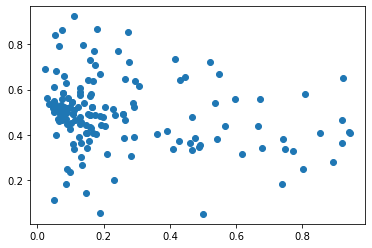

In [8]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

#### Processing
'SubID' column can be dropped as it is not used for analysis.

In [9]:
df_pvl_delta.drop(columns=['SubID'], inplace=True)

In [10]:
df_pvl_delta.head()

,group,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,0.159011,0.487522,0.686815,0.954498
1,young,0.064666,0.511008,1.391790,0.295529
2,young,0.113089,0.465141,0.918734,0.533232
3,young,0.089273,0.500391,0.703737,0.869859
4,young,0.233898,0.488053,0.897867,0.511095


### Read in data from the ORL model

In [11]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [12]:
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


#### Processing
'subjID' column in input file is actually the 'group' column based on its contents. Thus, rename the column as so.

In [13]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

,group,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


### Read in data from the VPP model

In [14]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [15]:
df_vpp.head()

,group,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,1,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,2,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,3,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,4,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,5,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


#### Processing
'SubID' column is dropped as before as it is not used for analysis.

In [16]:
df_vpp.drop(columns=['SubID'], inplace=True)
df_vpp.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


# =============================================================

# 2. Standardising the Data

# =============================================================

In the paper, Lili concludes that the VPP model was the best-fitting model in terms of short-term prediction performance for the IGT task, as measured by one-step-ahead leave-one-out information criterion (LOOIC). Therefore, we will begin by analysing this dataset. The *'group'* column will not be used as a feature for the clustering analysis, so we will exclude this from the processing for now.

In [24]:
df_vpp_sd = df_vpp.iloc[:, 1:]

If we look at the ranges of the variables in the *df_vpp* DataFrame and their distributions...

In [33]:
df_vpp_sd.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.070824,0.560575,1.329323,0.952138,0.460940,-0.720379,0.406367,0.622995
std,0.064683,0.111139,0.198041,0.580621,1.185591,1.102656,0.187483,0.066657
min,0.027454,0.352471,0.879707,0.193857,-2.977630,-2.912838,0.042780,0.452978
25%,0.038294,0.448811,1.202790,0.528927,-0.287230,-1.634716,0.256420,0.569390
50%,0.050247,0.590334,1.316736,0.760613,0.593115,-0.779120,0.439912,0.640917
75%,0.078495,0.646090,1.428836,1.292569,1.419412,0.137599,0.565139,0.675971
max,0.617431,0.818137,1.938694,2.698527,2.559126,1.583109,0.858421,0.744017


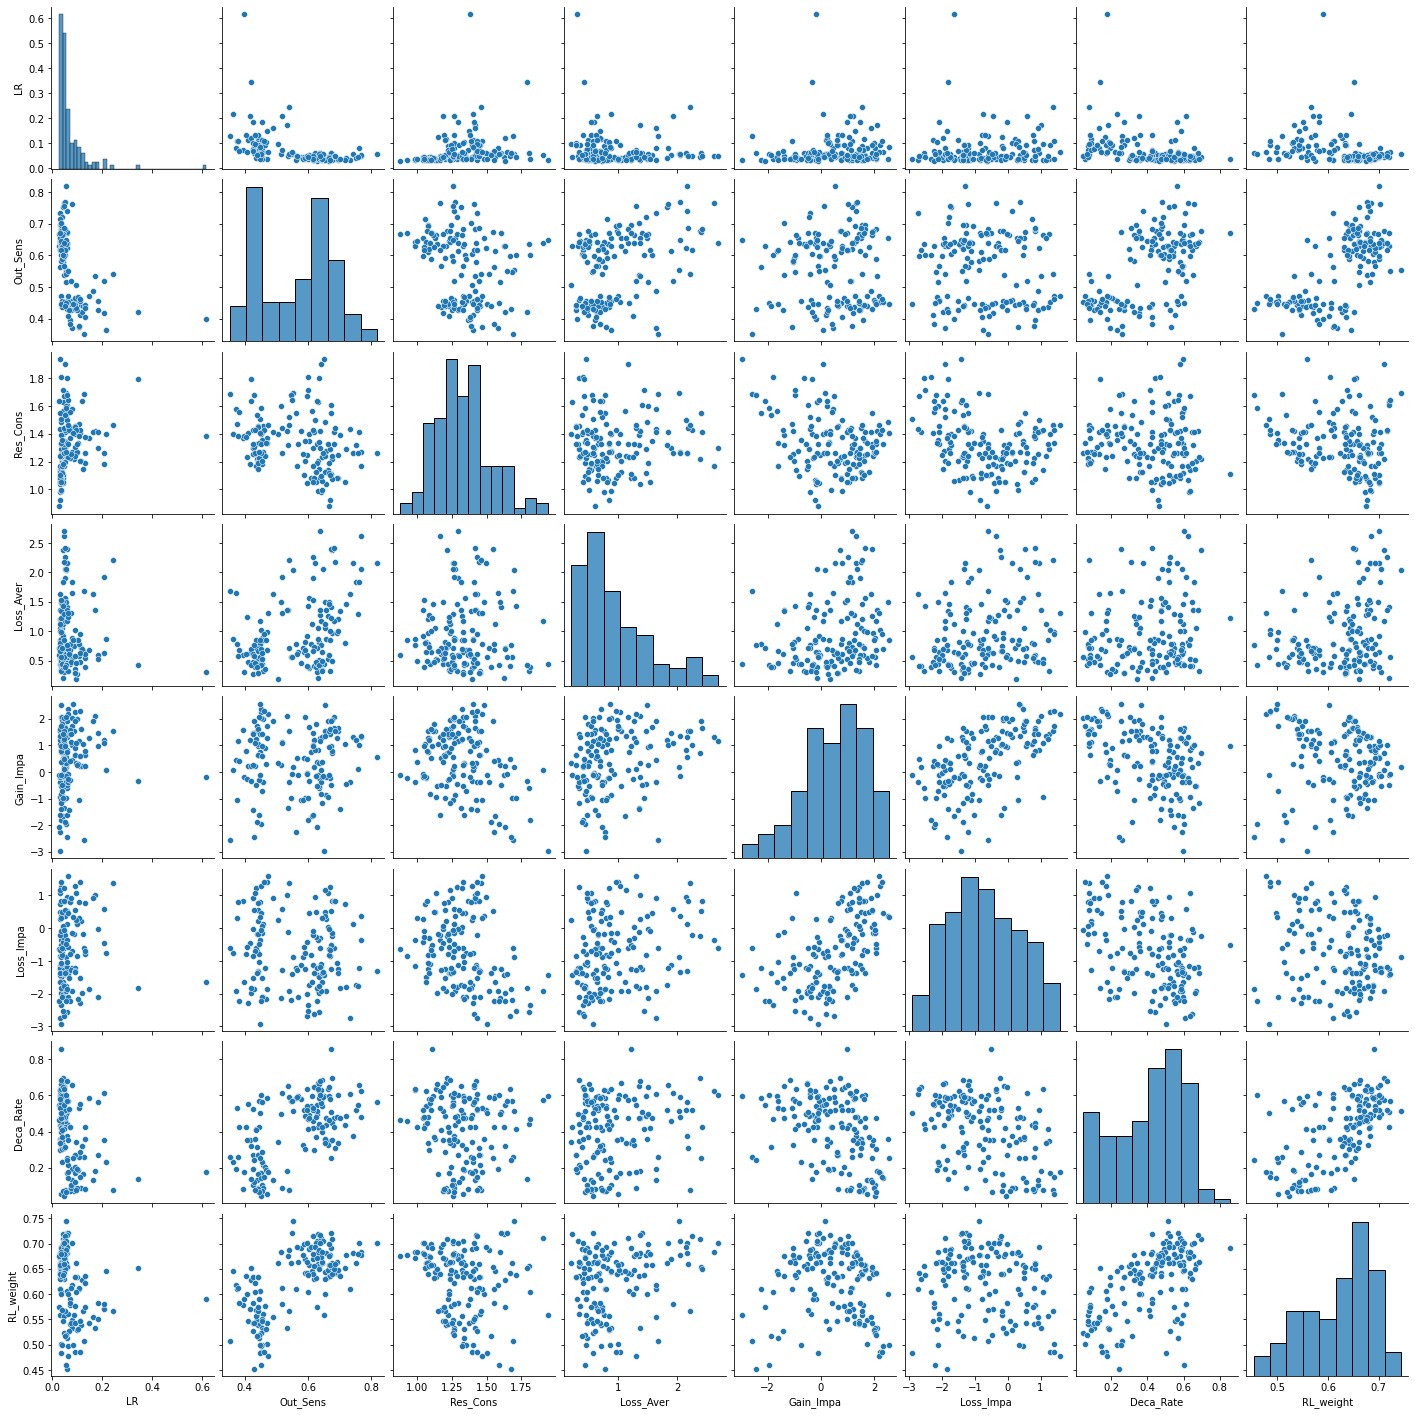

In [32]:
#Visualising the distributions of the different variables
sns.pairplot(df_vpp_sd)

From the pair plot above, we can clearly see that many of the variables have either positively or negatively skewed distributions. There also appears to be many outliers in each distribution and the different parameters don't share a common scale. 

To remedy this and also to ensure sound clustering analysis, we are going to **standardise** the dataset. We may also perform some principal component analysis on the data and to allow for this, the data will need to be standardised anyway.

#### Standardising the features

In [39]:
#Scaling the data
array_vpp_scaled = StandardScaler().fit_transform(df_vpp_sd)

#Normalizing the data
array_vpp_norm = normalize(array_vpp_scaled)

#Converting the standardised array back to a DataFrame
df_vpp_sd = pd.DataFrame(array_vpp_norm, columns=df_vpp_sd.columns)

In [40]:
df_vpp_sd.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,-0.020336,0.011143,-0.007340,-0.000307,-0.002791,-0.002880,0.008144,0.009668
std,0.318101,0.357772,0.363945,0.359315,0.360013,0.358561,0.359069,0.357698
min,-0.404640,-0.777566,-0.807861,-0.669812,-0.786274,-0.700567,-0.799632,-0.649735
25%,-0.262365,-0.320904,-0.235453,-0.255578,-0.265683,-0.297872,-0.269670,-0.305098
50%,-0.114833,0.102960,0.014403,-0.106258,0.042066,-0.020958,0.074008,0.074764
75%,0.105957,0.294110,0.214385,0.293106,0.282949,0.289779,0.281255,0.306457
max,0.979417,0.710403,0.832442,0.876844,0.794385,0.765549,0.777542,0.617943


#### Add the group feature back in

Since the data is now fully processed and ready for clustering, we can add the *'group'* column back in as it will be needed later on.

In [41]:
df_vpp_sd = pd.concat([df_vpp.iloc[:, 0], df_vpp_sd], axis=1)

In [42]:
df_vpp_sd.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,-0.273711,0.258373,-0.236811,0.103057,-0.381986,-0.473107,0.609875,0.223459
1,young,-0.158959,0.211519,0.602357,-0.462825,-0.190765,-0.224575,0.026794,0.515177
2,young,-0.242151,0.177420,0.214385,-0.492437,-0.355720,-0.455659,0.222972,0.487393
3,young,-0.298645,0.277743,-0.552474,-0.075495,-0.265683,-0.297872,0.504985,0.329268
4,young,-0.018640,0.181119,0.747803,-0.298616,-0.272331,-0.479506,0.038330,0.113618


# =============================================================

# Consideration of Clustering Algorithms

# =============================================================

There are a number of clustering algorithms which we could implement. Below, we try the *KMeans* and *Spectral Clustering* algorithms and analyse how these perform on the data in question. 

To determine which algorithm is more appropriate to the dataset, we will measure their performance using the *Silhouette Coefficient*. The Silhouette Coefficient of a data point quantifies how similar a data point is to its own cluster compared to other clusters. We will use the mean Silhouette Coefficient across all data points to compare the performace of algorithms.

The **Silhouette Coefficient** for a particular data point is calculated by the below formula:

$$s = \frac{b - a}{max(a, b)}$$

Where:

 - **a** is the mean distance between a data point and all other points in the same cluster. (the mean intra-cluster distance)
 - **b** is the mean distance between a data point and all other points in the *next nearest cluster*. (the mean nearest-cluster distance)

The Silhouette score can assume values between -1 and 1. Scores closer to -1 indicate incorrect clustering whereas those nearer to +1 indicate highly dense clustering. Scores around zero are indicative of overlapping clusters. Therefore, a good indicator of what clustering algorithm to choose would be the one whose mean Silhouette Coefficient is nearest to 1.


Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53–65. doi:10.1016/0377-0427(87)90125-7.

In [45]:
df_cluster = df_vpp_sd.iloc[:, 1:]

## Silhouette Scores for the KMeans Algorithm

Below the KMeans algorithm is executed with various different numbers of clusters (from 2 clusters to 10). The mean Silhouette Coefficient (or more simply, the *Silhouette Score*) for the clusters produced is calculated for each execution of the algorithm. These scores are plotted below.

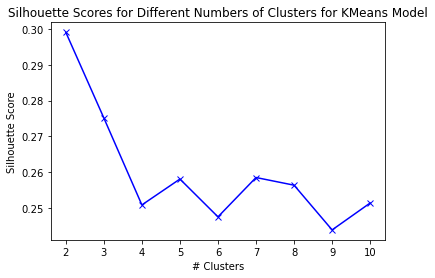

In [53]:
# Initialise empty list for the Silhouette Scores for KMeans model
s_scores_km = []
num_clusters_to_iter = range(2, 11)

# Running algorithm and calculating Silhouette Score
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    km_model = KMeans(n_clusters = k)

    # Training the model and storing the predicted cluster labels
    km_labels = km_model.fit_predict(df_cluster)
    
    # Evaluating the performance and adding score to list
    s_scores_km.append(silhouette_score(df_cluster, km_labels))

plt.plot(num_clusters_to_iter, s_scores_km, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters for KMeans Model')
plt.show()

#### Plot the elbow curve of the distortion that each cluster number gives

In [47]:
#Need to figure out where this goes

plt.plot(num_clusters_to_iterate, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method displaying the optimal number of clusters')
plt.show()

NameError: name 'num_clusters_to_iterate' is not defined

## Silhouette Scores for Spectral Clustering Algorithm

In order to explore more options for clustering, we are going to test the performance of two different implementations of the Spectral Clustering algorithm. One implementation constructs the *affinity matrix* using a radial basis function (RBF) kernel (aka Gaussian kernel) while the other constructs this matrix by computing a graph of nearest neighbors.

#### Spectral Clustering with *affinity='rbf'*

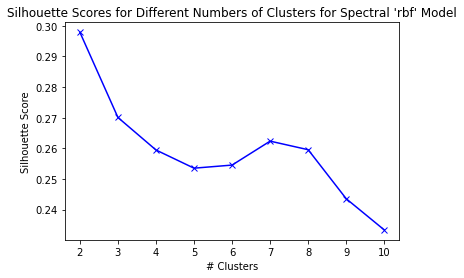

In [52]:
# Initialise empty list for the Silhouette Scores for Spectral 'rbf' model
s_scores_rbf = []

# Running algorithm and calculating Silhouette Score
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    spectral_model_rbf = SpectralClustering(n_clusters = k, affinity ='rbf')

    # Training the model and storing the predicted cluster labels
    labels_rbf = spectral_model_rbf.fit_predict(df_cluster)
    
    # Adding Silhouette Score to list
    s_scores_rbf.append(silhouette_score(df_cluster, labels_rbf))

plt.plot(num_clusters_to_iter, s_scores_rbf, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters for Spectral \'rbf\' Model')
plt.show()

#### Spectral Clustering with *affinity='nearest_neighbors'*

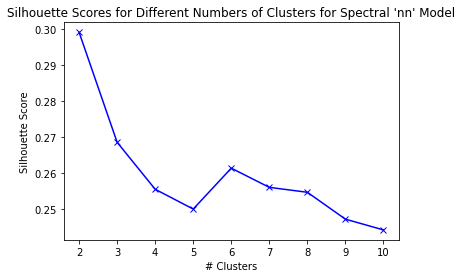

In [54]:
# Initialise empty list for the Silhouette Scores for Spectral 'nearest_neighbors' model
s_scores_nn = []

# Running algo and storing Silhouette Score for each no. of clusters
for k in num_clusters_to_iter:
    
    # Building the clustering model
    spectral_model_nn = SpectralClustering(n_clusters = k, affinity ='nearest_neighbors')

    # Training the model and storing the predicted cluster labels
    labels_nn = spectral_model_nn.fit_predict(df_cluster)
    
    # Evaluating the performance 
    s_scores_nn.append(silhouette_score(df_cluster, labels_nn))

plt.plot(num_clusters_to_iter, s_scores_nn, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters for Spectral \'nn\' Model')
plt.show()

Splitting the data into *two clusters* produces the best Silhouette Scores for all three algorithms. This is probably to be expected as the sample of data subjects can be segmented into two groups as we saw at the start; *'young'* and *'old'* and there is a good chance that the two clusters encapsulates these two groups. However, to confirm this, we will attempt to visualise these clusters. 

We will test the Spectral Clustering algorithm, with 'rbf' used to construct the affinity matrix, using two clusters.

# =============================================================

# 4. Cluster the data

# =============================================================

In [55]:
# Building Spectral model with 2 clusters
spectral_model = SpectralClustering(n_clusters=2, affinity='rbf')

# Training the model and storing predicted cluster labels
labels = spectral_model.fit_predict(df_cluster)

In order to visualise these clusters, we will need to reduce the dimensionality of the original Dataframe so that we can represent each data point in a two dimensional space. This can be achieved by performing **Principal Component Analysis** on the data. This is done below.

In [ ]:
# Move PCA up here?

In [ ]:
#Choose more clusters
#The next most suitable combination of num_clusters/model is kmeans with 6 clusters
#Confirm this with elbow curve

kmeans = KMeans(n_clusters=6).fit(standard_train_array)
centroids = kmeans.cluster_centers_

## Find out which of the clusters each df row is in

#### Cluster the data

In [ ]:
clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit(standard_train_array)
clusters_label = pd.DataFrame(clustering.labels_).rename(columns={0: "Cluster"})

#### Calculate the centroids of the clusters

In [ ]:
kmeans = KMeans(n_clusters=num_clusters).fit(standard_train_array)
centroids = kmeans.cluster_centers_

#### Add a new column to the original data with the cluster each row is in

In [ ]:
full_df_nd_cluster = pd.concat([original_df, clusters_label], axis=1)

In [ ]:
full_df_nd_cluster.head()

# =============================================================

# 5. Principal Component Analysis

# =============================================================

There are eight parameters in this model so principal component analysis is performed below on the data before performing Spectral clustering.

#### Inspect dataframe which PCA is being performed on

In [ ]:
original_df.head()

#### Use PCA to project the data to 2 dimensions

In [ ]:
pca = PCA(n_components=2)

principal_components_array = pca.fit_transform(standard_train_array)

#### Look at how much variance these 2 axes explain

In [ ]:
pca.explained_variance_ratio_

#### Add these principal component columns to the rest of the data

In [ ]:
principal_df = pd.DataFrame(data = principal_components_array, columns = ['Principal_Component_1', 'Principal_Component_2'])
principal_df.head()

In [ ]:
final_df = pd.concat([full_df_nd_cluster, principal_df], axis = 1)

In [ ]:
final_df.head()

# =============================================================

# 6. Plot the clusters with the PCA axes

# =============================================================

## Plot the clusters

#### Choose the columns to plot

In [ ]:
pc1 = final_df['Principal_Component_1']
pc2 = final_df['Principal_Component_2']
group = final_df["group"]
cluster = final_df["Cluster"]

#### Visualise 2D projection

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Plotting the dataset accross the 2 principal components', fontsize = 20)

targets = ['young', 'old']
colors = ['b', 'y']

for target, color in zip(targets, colors):
    ax.scatter(pc1.loc[target == group], pc2.loc[target == group], c = color, s = 50)
    
ax.legend(targets)
ax.grid()

#### Plot the original data

In [ ]:
plt.scatter(pc1, pc2)

#### Plot the data colouring the different groups

In [ ]:
plt.scatter(pc1, pc2, c=np.where(0, 1, group=="young"), s=50)

#### Plot this data colouring the different clusters

In [ ]:
plt.scatter(pc1, pc2, c=cluster, s=50)

#### Plot this data with the clusters and their centroids

In [ ]:
plt.scatter(pc1, pc2, c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# =============================================================

# 7. Analyse the clusters

# =============================================================

## See how the 'Old' and 'Young' fall into these clusters

In [ ]:
final_df.head()

#### Create a dataframe showing how many people people fell into each cluster

In [ ]:
all_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [ ]:
final_df["group"] = final_df["group"].replace('old', np.nan).replace('young', 1)

#### Create a dataframe showing how many young people fell into each cluster

In [ ]:
young_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [ ]:
old_cluster_df = pd.DataFrame(final_df["group"].isnull().groupby(final_df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [ ]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")